## Recurrent Neural Networks

Recurrent neural networks - or RNNs - are built specifically to deal with sequence data. For example, suppose you have a sequence of text of movie reviews and would like to classify their sentiment, or a sequence of stock prices and you would like to predict the next one. These are all tasks well suited for an RNN.

To better understand, let's take a look at this blog post:

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

RNN's can take many different forms:

* Sequence of inputs to sequence of outputs
* Sequence of inputs to vector of output
* Vector of input to sequence of outps
* Encoder -> Decoder

We can take a closer look on p. 384 of Hands on Machine Learning

## Variable length sequences

If you have variable length inputs, like movie reviews which differ in length. A decent technique is to pick a fairly large input sequence length and zero padd all the inputs which are smaller. See here:

https://github.com/keras-team/keras/issues/40

If you have variable length output sequences - for example, when generating text. You can define a special end of sequence tag such as <EOS> and ignore any output past that tag.


## Issues with RNNs:

* Vanishing/Exploding gradients
* Take a long time to train
* Memory of first inputs tends to fad away making their long-term memory weak

## LSTM

## GRU

## Word Embeddings

## Encoder-Decoder

## Example of RNN using pytorch

Source: http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#sphx-glr-intermediate-char-rnn-generation-tutorial-py

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import defaultdict
%matplotlib inline

In [2]:
female_names = []
name_weights = []
for year in range(2000,2017):
    with open("../small_data/baby_names/yob{}.txt".format(year), "r") as f:
        for line in f:
            columns = line.split(",")
            if columns[1] == 'F':
                female_names.append(columns[0])
                name_weights.append(int(columns[2].strip()))

In [3]:
female_names[:5]

['Emily', 'Hannah', 'Madison', 'Ashley', 'Sarah']

In [4]:
n_names = len(female_names)
print(n_names)

326418


In [5]:
name_weights[:5]

[25953, 23078, 19967, 17996, 17691]

In [6]:
unique_names_weights = defaultdict(int)
for i in range(n_names):
    name = female_names[i]
    weight = name_weights[i]
    unique_names_weights[name] = unique_names_weights[name] + weight

In [7]:
unique_names = list(unique_names_weights.keys())
unique_weights = list(unique_names_weights.values())
unique_probabilities = np.array(unique_weights) / sum(unique_weights)

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [9]:
letters = set([c.lower() for name in female_names for c in name])
letters_to_index = {l:i for i,l in enumerate(letters)}
index_to_letter = {i:l for l, i in letters_to_index.items()}

In [10]:
n_letters = len(letters) + 1

In [11]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li].lower()
        tensor[li][0][letters_to_index[letter]] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [letters_to_index[line[li].lower()] for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingPair():
    return np.random.choice(unique_names, p=unique_probabilities, size=1)[0]

def randomTrainingExample():
    line = randomTrainingPair()
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return input_line_tensor, target_line_tensor

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
criterion = nn.NLLLoss()
rnn = RNN(n_letters, 128, n_letters)

optimizer = optim.Adam(rnn.parameters(), lr=.001)

def train(input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    optimizer.step()

    return output, loss.data[0] / input_line_tensor.size()[0]

In [13]:
n_iters = 10000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 10s (5000 50%) 1.8038
2m 36s (10000 100%) 2.0115


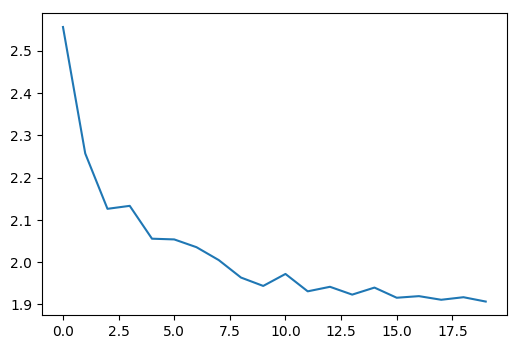

In [14]:
plt.plot(all_losses)

In [15]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A'):
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = index_to_letter[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

In [71]:
sample('Y')

'Ylane'